# Get started with Stable Diffusion using Flax and TPU
> Learn how to use Hugging Face's diffusers library to play with the Flax implementation of Stable Diffusion models and generate images from text on TPU.

- toc: false
- badges: true
- comments: true
- author: dzlab
- categories: [flax, vision, diffusers]

Diffusion models are some of the most recent disrubtive models. Outperforming generative models, they have been made popular as result of the success of [DALL-E 2](https://openai.com/dall-e-2/) or [Imagen](https://imagen.research.google/) to generate photorealistic images when prompted on text.

Thanks to Hugging Face, Diffusion models are available to anyone to use via the [diffusers](https://github.com/huggingface/diffusers) library. In this post, we will explore the `diffusers` Flax API to generate images from a prompt.

## Setup & Imports

First, we need to install some libraries include `diffusers` and `Flax`.

In [ ]:
%%capture
%%bash

pip install --upgrade diffusers transformers scipy
pip install --upgrade flax

The diffusers librar contains the Flax implementation of the model, but we need to also use some weights to initialize it. We will use checkpoints from [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), but first we need to accept the terms of the licence for this model.

One running the following cell, it will asks for an access token which you can get from the settings page of your Hugging Face account - [link](https://huggingface.co/settings/tokens).

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


We need to setup JAX to use TPU to, see [link](https://github.com/google/jax#pip-installation-colab-tpu).

In [ ]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

We need to make sure that JAX is using TPU as backend before proceeding further
> Note: The number of TPU cores is displayed, this should be 8 if you are running on a v2 or v3 TPU or 4 if you are running on a v4 TPU.

In [ ]:
assert jax.device_count() == 8

Import the libraries we will use, e.g. matplotlib for plotting the resulting images.

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from flax.jax_utils import replicate
from flax.training.common_utils import shard
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Loading the models

Now, we can instanciate a Flax Diffusion pipeline and load the propoer weights.

Note: we are using half-precision weights (i.e. `float16` wheras the original model weights are in `float32`) to save on memory and avoid issues like OOM.


In [ ]:
from diffusers import FlaxStableDiffusionPipeline

pipeline, pipeline_params = FlaxStableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", revision="bf16", dtype=jax.numpy.bfloat16
)

If you want to use the orignal precision (i.e. float32) then you need to change how the pipeline is loaded to this:
```python
pipeline, pipeline_params = FlaxStableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", revision="flax", dtype=jax.numpy.bfloat32
)
```

## Helper functions

The input promot is text, we need to be able to convert it to numbers as expected by this Diffusion model. Hence, the following function wraps `pipeline.prepare_inputs` to properly convert the text to Token IDs.

In [ ]:
def prepare_inputs(prompt, num_samples):
    prompt = num_samples * [prompt]
    prompt_ids = pipeline.prepare_inputs(prompt)
    prompt_ids = shard(prompt_ids)
    return prompt_ids


The next helper function will run the pipeline with the input prompt text. This will generate a JAX represnetation of the image corresponding to that prompt. We will at the end covert this JAX array into an actual PIL image.

In [ ]:
def generate1(prompt, num_samples, seed=0, num_inference_steps=50, guidance_scale=7.5):
    prng_seed = jax.random.PRNGKey(seed)
    prompt_ids = prepare_inputs(prompt, num_samples)

    # shard inputs and rng
    params = replicate(pipeline_params)
    prng_seed = jax.random.split(prng_seed, num_samples)

    output = pipeline(prompt_ids, params, prng_seed, num_inference_steps, guidance_scale=guidance_scale, jit=True)
    images = output.images
    images = np.asarray(images.reshape((num_samples,) + images.shape[-3:]))
    images = pipeline.numpy_to_pil(images)
    return images

Our final helper function is for plotting the model output images into a grid.

In [ ]:
def ceildiv(a, b):
    return -(-a // b)

def plots_pil_images(pil_images, figsize=(10,5), rows=1, cols=None, titles=None, maintitle=None):
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    cols = cols if cols else ceildiv(len(pil_images), rows)
    for i in range(len(pil_images)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = np.asarray(pil_images[i])
        plt.imshow(img)

## Generating images

The main input to the Stable Diffusion pipeline is the text describing what we want the model to render, aka prompt.

In [ ]:
prompt = "A road across trees with snow and moutains in the horizon in fresco style"

You can try your own prompts, for instance:

    A city, morning sunrise, clouds, beautiful, summer, calm
    Paris by night, studio ghibli, art by hayao miyazaki
    Hyperrealist photo of a ford mustang
    . . .

You can also try other painting style like: Expressionist, Oil, Surrealism. See more here - [link](https://www.pictoclub.com/types-of-painting-art-styles-mediums-subjects/)

The only limit is our imagination. Note that you may need many iteration on your promot to endup with an image close to what you actually want.

In [ ]:
num_samples = jax.device_count()

Let's pass our prompt to the pipeline and examine the different images that the model generated.

CPU times: user 8.25 s, sys: 15.2 s, total: 23.5 s
Wall time: 34.7 s


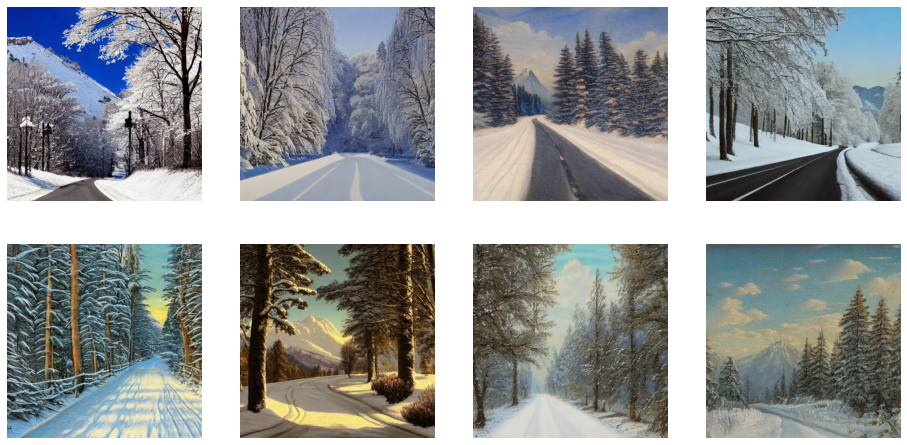

In [ ]:
%%time

images = generate1(prompt, num_samples, seed=0)
plots_pil_images(images, figsize=(16, 8), rows=2, cols=num_samples/2)

> Note: because we are using a TPU which have 8 cores, we needed to duplicate the prompt 8 times which explains why we get back 8 images.

We can changing the seed which will result in the model returning completely different images for the same prompt

CPU times: user 8.64 s, sys: 12.9 s, total: 21.5 s
Wall time: 34 s


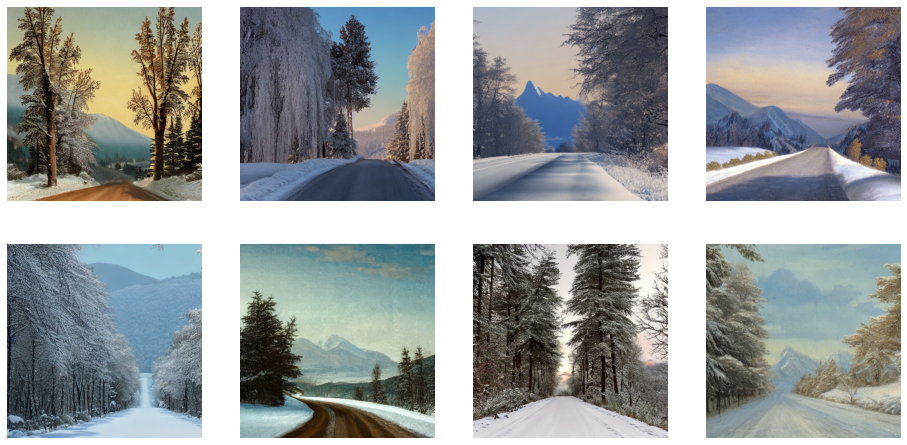

In [ ]:
%%time

images = generate1(prompt, num_samples, seed=13)
plots_pil_images(images, figsize=(16, 8), rows=2, cols=num_samples/2)

### Guidance scale

Another parameter to control the look and quality of the resulting image is `guidance_scale`. To better understand what this value does we need to understand how the model generate an image.

Stable Diffusion is a multi-step model. At each step, the model predicts some noise using the input prompt and combines this with noise generating from blank input (i.e. empty string) as follows:

```python
noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
```

In this case, `noise_pred_uncond` is the noise predicted from a blank input, and `noise_pred_text` is the noise predicted from the input prompt.

The parameter `guidance_scale` controls how mush difference (or we can think of it as distance) of `noise_pred_uncond` to `noise_pred_text` the model we will incorporate in our final image. The value of `guidance_scale` can be anything but usual `7.5` seem to provide good results.

Let's try `1.1` as a value for our guidance and examine the resulting images.

CPU times: user 9.31 s, sys: 11.6 s, total: 20.9 s
Wall time: 33.4 s


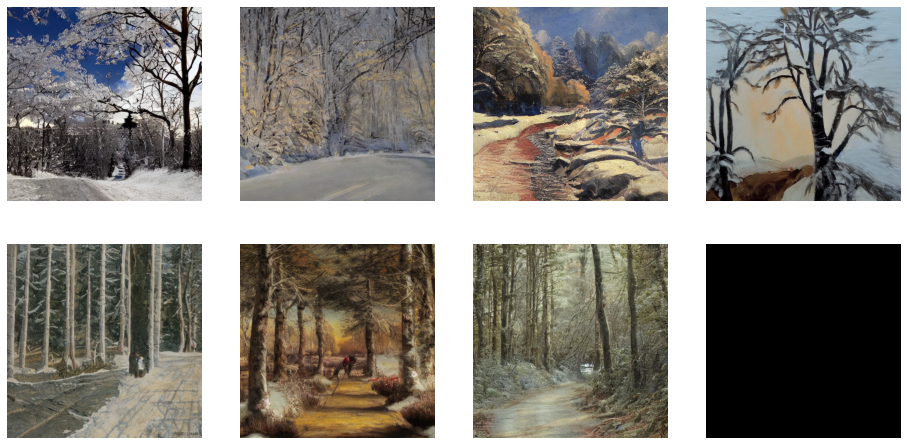

In [ ]:
%%time

images = generate1(prompt, num_samples, seed=0, guidance_scale=1.1)
plots_pil_images(images, figsize=(16, 8), rows=2, cols=num_samples/2)

You may notice that the resulting images are not as close to our prompt then the ones generated earlier using the default value of `7.5`.

### Negative prompt

The Stable Diffusion pipeline accepts a paramter called `neg_prompt_ids`. This is basically the Token IDs of a Negative prompt.

In simple terms, a negative prompt instructs the Stable Diffusion model to not include certain things in the generated image. This allow us to remove any object, styles, or abnormalities from the original generated image.

In [ ]:
def generate2(prompt, neg_prompt, num_samples, seed=0, num_inference_steps=50, guidance_scale=7.5):
    prng_seed = jax.random.PRNGKey(seed)
    prompt_ids = prepare_inputs(prompt, num_samples)
    neg_prompt_ids = prepare_inputs(neg_prompt, num_samples)

    # shard inputs and rng
    params = replicate(pipeline_params)
    prng_seed = jax.random.split(prng_seed, num_samples)

    output = pipeline(prompt_ids, params, prng_seed, num_inference_steps, guidance_scale=guidance_scale, jit=True,
                      neg_prompt_ids=neg_prompt_ids)
    images = output.images
    images = np.asarray(images.reshape((num_samples,) + images.shape[-3:]))
    images = pipeline.numpy_to_pil(images)
    return images

Let's tell Stable Diffusion to not include the sun

CPU times: user 8.69 s, sys: 13.3 s, total: 22 s
Wall time: 33.5 s


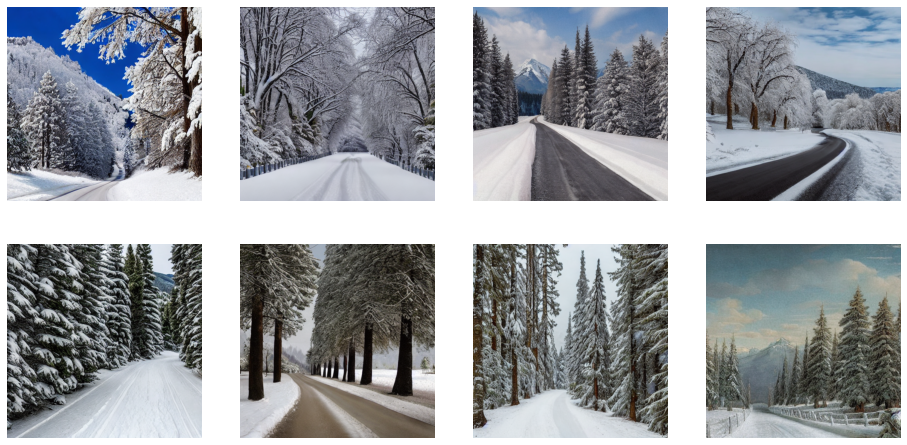

In [ ]:
%%time

images = generate2(prompt, 'shiny sun', num_samples, seed=0)
plots_pil_images(images, figsize=(16, 8), rows=2, cols=num_samples/2)

Let's make sure Stable Diffusion does not generate images of sunnet

CPU times: user 10.1 s, sys: 12.8 s, total: 22.9 s
Wall time: 33.2 s


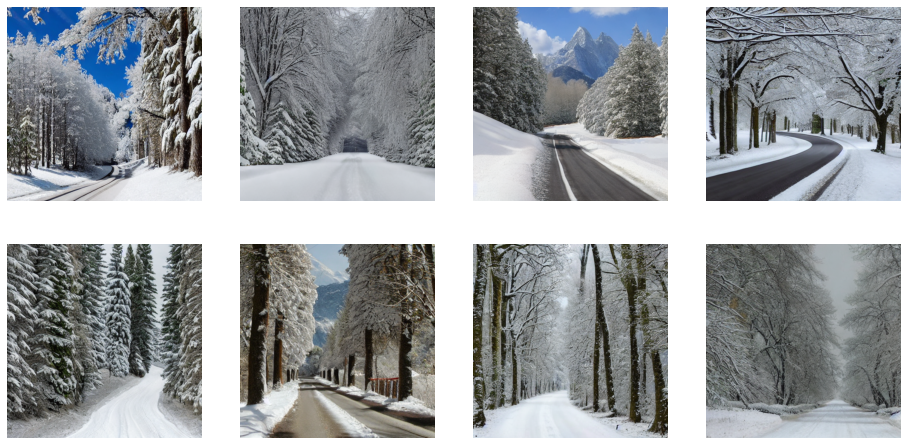

In [ ]:
%%time

images = generate2(prompt, 'sunset', num_samples, seed=0)
plots_pil_images(images, figsize=(16, 8), rows=2, cols=num_samples/2)

Let's try not having snow storms, and notice how the model removed snow from the resulting images.

CPU times: user 8.74 s, sys: 12.8 s, total: 21.5 s
Wall time: 33.2 s


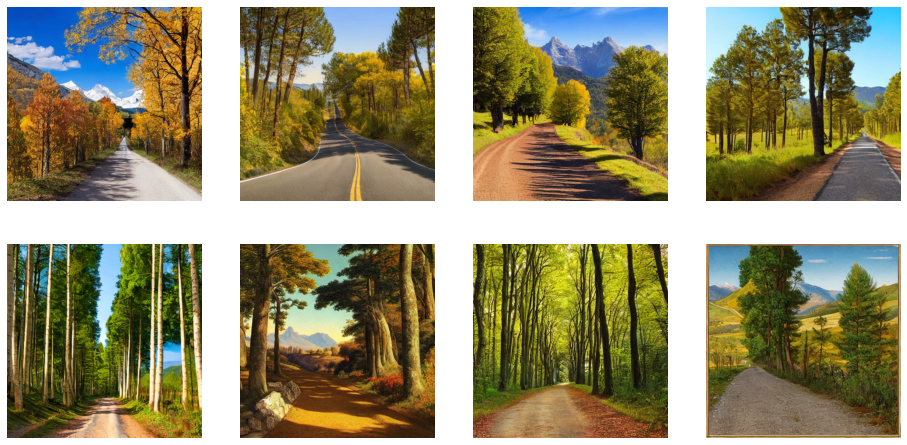

In [ ]:
%%time

images = generate2(prompt, 'snow storm', num_samples, seed=0)
plots_pil_images(images, figsize=(16, 8), rows=2, cols=num_samples/2)

## That's all folks

Stable Diffusion is a very neat model, and Hugging Face's diffusers library makes it very easy to play with such models. Furthermore, with the Flax implementation and the use of TPUs we can generate images and play with the model in an almost interactive way.

I hope you enjoyed this article, feel free to leave a comment or reach out on twitter [@bachiirc](https://twitter.com/bachiirc).